## Import Libraries

In [ ]:
import os
import gdown
import zipfile
import numpy as np
import shutil
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Dataset

In [ ]:
# 450
!gdown --id 1O5-f4WlXnoruddVRpnBp607gW2wEZ3C2


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O5-f4WlXnoruddVRpnBp607gW2wEZ3C2
From (redirected): https://drive.google.com/uc?id=1O5-f4WlXnoruddVRpnBp607gW2wEZ3C2&confirm=t&uuid=ed1d8611-8102-438c-ac19-33ff8b814604
To: /content/murni_dataset.zip
100% 70.2M/70.2M [00:03<00:00, 20.9MB/s]


In [ ]:
# Path of downloaded ZIP file
zip_path = "/content/murni_dataset.zip"

# Extraction destination folder path
extract_path = "/content/dataskin"

# Ektraction file
if zip_path.endswith(".zip"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"The dataset was successfully extracted to {extract_path}")

for folder_name in os.listdir(extract_path):
  print(folder_name, ":", len(os.listdir(os.path.join(extract_path, folder_name))), 'files')


The dataset was successfully extracted to /content/dataskin
oily : 355 files
normal : 359 files
dry : 358 files


## **Preprocessing**

# Split Dataset

In [ ]:
# Folder to split dataset
base_dir = "/content/dataset_splitting"
os.makedirs(base_dir, exist_ok=True)

# train, val, test folder
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# train, val, test subfolder
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

classes = ['dry', 'normal', 'oily']

for class_name in classes:
    class_dir = os.path.join(extract_path, class_name)

    if os.path.isdir(class_dir):
        print(f"\nSplitting dataset for classes: {class_name}")

        images = os.listdir(class_dir)
        images = [os.path.join(class_dir, img) for img in images]

        # Divide the dataset into train (70%), val (10%), test (10%)
        train_imgs, test_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

        # Create subfolders for classes in train, val, test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move the images to subfolders
        for img in train_imgs:
            shutil.copy(img, os.path.join(train_dir, class_name))
        for img in val_imgs:
            shutil.copy(img, os.path.join(val_dir, class_name))
        for img in test_imgs:
            shutil.copy(img, os.path.join(test_dir, class_name))

print("\nThe dataset has been divided into training, validation, and testing.")


Splitting dataset for classes: dry

Splitting dataset for classes: normal

Splitting dataset for classes: oily

The dataset has been divided into training, validation, and testing.


In [ ]:
# Training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)

# Validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)

# Test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)
print(train_dataset.class_names)

Found 749 files belonging to 3 classes.
Found 160 files belonging to 3 classes.
Found 162 files belonging to 3 classes.
['dry', 'normal', 'oily']


## Normalization Dataset

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

## Optimize Dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Augmentation Data

In [ ]:
# Data Augmentation model
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomContrast(0.2)
        ])

## Create Model

In [ ]:
def create_model():
    base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam (learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,947 (91.01 MB)

 Trainable params: 270,979 (1.03 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [ ]:
# Train model
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                    )

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3715 - loss: 1.7199 - val_accuracy: 0.4875 - val_loss: 1.1029
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step - accuracy: 0.4195 - loss: 1.5170 - val_accuracy: 0.5750 - val_loss: 1.0053
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.4815 - loss: 1.3845 - val_accuracy: 0.6125 - val_loss: 0.9224
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.5913 - loss: 1.0704 - val_accuracy: 0.6375 - val_loss: 0.8762
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.5813 - loss: 1.0855 - val_accuracy: 0.6375 - val_loss: 0.8412
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6197 - loss: 0.9650 - val_accuracy: 0.6562 - val_loss: 0.8051
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.6235 - loss: 0.9342 - val_accuracy: 0.6812 - val_loss: 0.7793
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.6612 - loss: 0.9436 - val_accura

## Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7750 - loss: 0.5588
Validation Loss: 0.5436246395111084
Validation Accuracy: 0.768750011920929


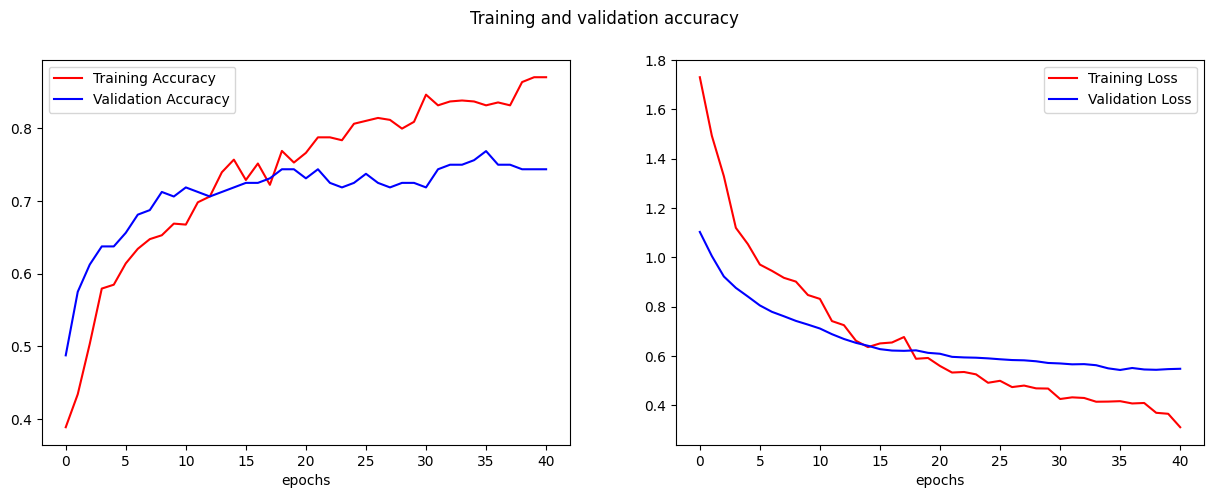

In [ ]:
# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# len epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# Model evaluation using test_dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Evaluation results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 801ms/step - accuracy: 0.7717 - loss: 0.5474
Test Loss: 0.5284315347671509
Test Accuracy: 0.7777777910232544


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


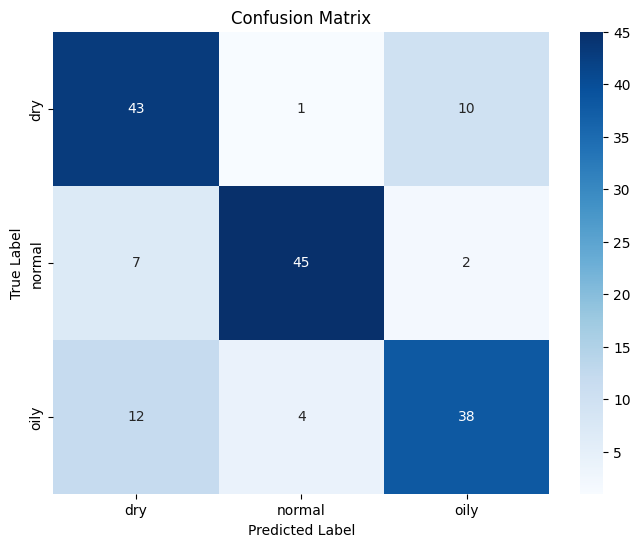

Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

         dry       0.69      0.80      0.74        54
      normal       0.90      0.83      0.87        54
        oily       0.76      0.70      0.73        54

    accuracy                           0.78       162
   macro avg       0.78      0.78      0.78       162
weighted avg       0.78      0.78      0.78       162



In [ ]:
class_names = ['dry', 'normal', 'oily']

# Model prediction
y_true = []
y_pred_probs = []

# Batch looping in test_dataset (augmentation)
for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Save original label

# Convert to numpy array
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)  # prediction label of probability

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)

# Result print
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)


Found 162 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


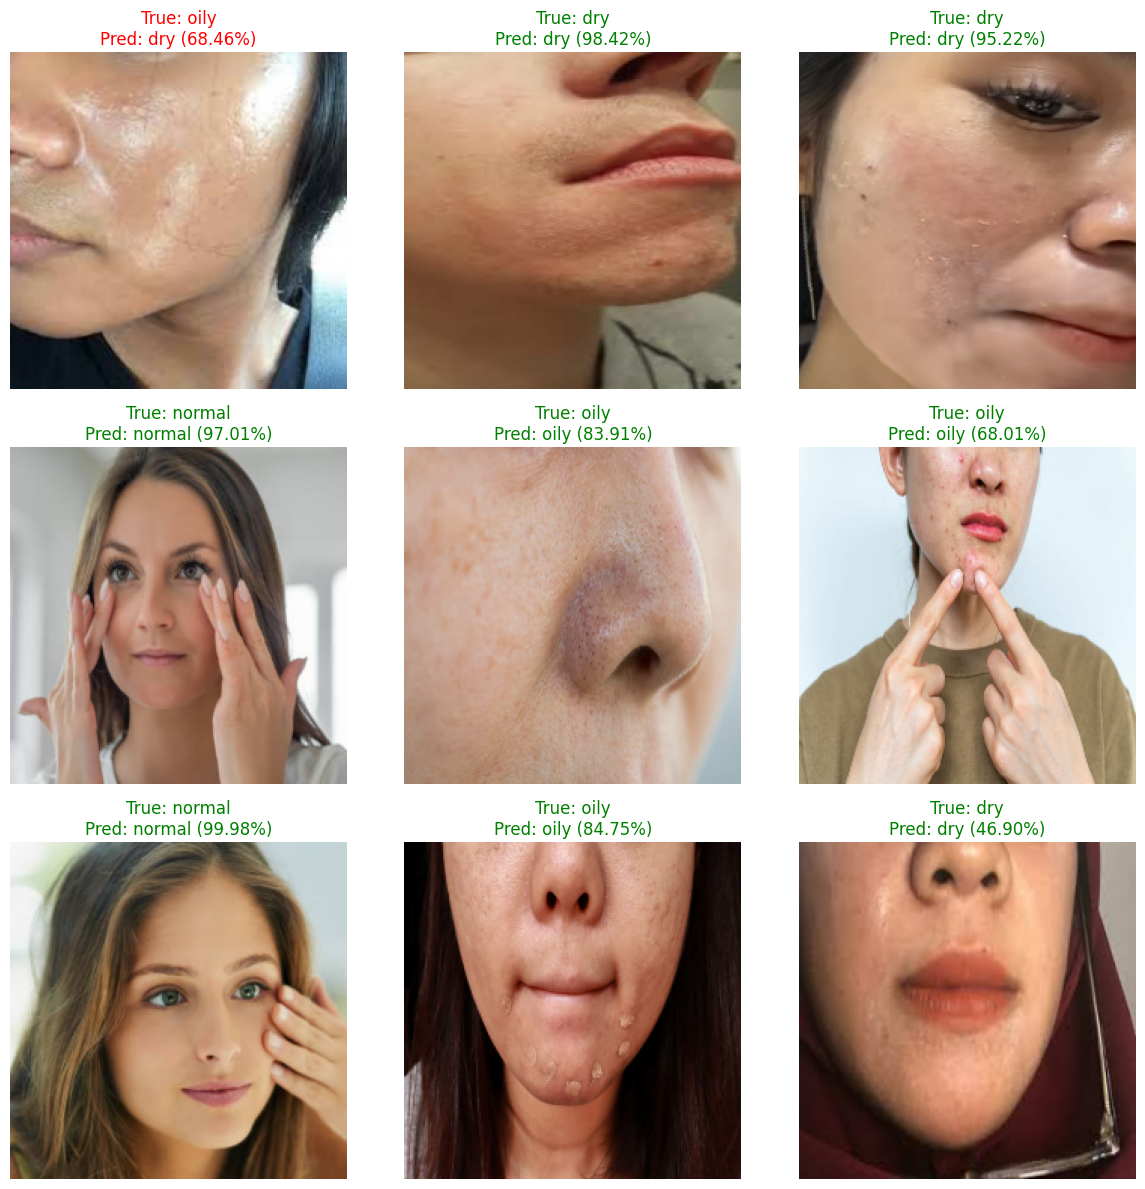

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

test_dataset_dir = '/content/dataset_splitting/test'
batch_size = 32
img_height, img_width = 224, 224


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = test_dataset.class_names

def display_predictions_with_probabilities(dataset, model, class_names, num_images=9):
    """
    Menampilkan gambar dengan label asli, label prediksi, dan persentase probabilitas.
    """
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        predicted_probs = np.max(predictions, axis=1)

        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i]]
            predicted_label = class_names[predicted_classes[i]]
            probability = predicted_probs[i] * 100


            color = "green" if true_label == predicted_label else "red"
            plt.title(f"True: {true_label}\nPred: {predicted_label} ({probability:.2f}%)", color=color)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

display_predictions_with_probabilities(test_dataset, model, class_names, num_images=9)


In [ ]:
# Saved model h5
model.save('SKINORY.h5')
